In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_files
from pyvi import ViTokenizer
from sklearn import svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
%matplotlib inline

In [11]:
data_train = load_files(container_path = "data/news_1135/", encoding = "utf-8")
print(data_train.filenames)
print()
print("Tong so file: {}".format( len(data_train.filenames)))
print("Danh sách nhãn và id tương ứng: ",  [(idx, name) for idx, name in enumerate(data_train.target_names)])

['data/news_1135/Tin kh†c/0218e1df21ce358b9c6485176a48f1fcaeedef67.txt'
 'data/news_1135/Khoa học - Công nghệ/bf9889f5f2ffd6c92fa877d35ef0ef5f34f0666d.txt'
 'data/news_1135/Tin kh†c/d74aab054ffe9f8661df13bc52b438b48a63fe48.txt'
 ... 'data/news_1135/Thời sự/a06c1ec4c146d3b4eb5070a1967e10e5e21bdc5b.txt'
 'data/news_1135/Sức khỏe/4187c4a1d528fd9ea4630d2709229df0b0d09c3d.txt'
 'data/news_1135/Thể thao/7adaf0c561796f2411340150f18417543ad4403c.txt']

Tong so file: 1135
Danh sách nhãn và id tương ứng:  [(0, 'Giải trí'), (1, 'Khoa học - Công nghệ'), (2, 'Kinh tế'), (3, 'Pháp luật'), (4, 'Sức khỏe'), (5, 'Thể thao'), (6, 'Thời sự'), (7, 'Tin kh†c'), (8, 'Độc giả'), (9, 'Đời sống - Xã hội')]


In [12]:
# load dữ liệu các stopwords 
with open("data/vietnamese-stopwords.txt", encoding="utf-8") as f:
    stopwords = f.readlines()
stopwords = [x.strip().replace(" ", "_") for x in stopwords] 
print(stopwords[:10])

# Transforming data 
# Chuyển hoá dữ liệu text về dạng vector tfidf 
#     - loại bỏ từ dừng
#     - sinh từ điển
module_count_vector = CountVectorizer(stop_words = stopwords)

model_rf_preprocess = Pipeline([('vect', module_count_vector),
                    ('tfidf', TfidfTransformer()),
                    ])
# Hàm thực hiện chuyển đổi dữ liệu text thành dữ liệu số dạng ma trận 
# Input: Dữ liệu 2 chiều dạng numpy.array, mảng nhãn id dạng numpy.array 
data_preprocessed = model_rf_preprocess.fit_transform(data_train.data, data_train.target)
# print(module_count_vector.vocabulary_)

print("10 từ đầu tiên trong từ điển:")
i = 0
for k,v in module_count_vector.vocabulary_.items():
    i+=1
    print(i, ": ", (k, v))
    if i > 10:
        break 


['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy', 'ai_đó', 'alô', 'amen', 'anh', 'anh_ấy']
10 từ đầu tiên trong từ điển:
1 :  ('dân_trí', 6928)
2 :  ('sở', 17869)
3 :  ('gd', 7729)
4 :  ('đt', 23214)
5 :  ('tỉnh', 20851)
6 :  ('gia_lai', 7816)
7 :  ('văn_bản', 21779)
8 :  ('2258', 858)
9 :  ('sgdđt', 17039)
10 :  ('vp', 21572)
11 :  ('chấn_chỉnh', 4971)


Exercise 1: Sử dụng trực tiếp TfidfVectorizer()

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf_vector = TfidfVectorizer(stop_words = stopwords)

data_tfidf = tfidf_vector.fit_transform(data_train.data, data_train.target)   

first_doc_vector = data_tfidf[0].toarray().flatten()
feature_names = np.array(tfidf_vector.get_feature_names_out())
sorted_tfidf = np.argsort(data_tfidf[0].toarray().flatten())[::-1]

print("\nTop 10 từ có giá trị TF-IDF cao nhất trong văn bản đầu tiên:")
for word, score in zip(feature_names[sorted_tfidf[:10]], first_doc_vector[sorted_tfidf[:10]]):
    print(f"{word}: {score:.2f}")


Top 10 từ có giá trị TF-IDF cao nhất trong văn bản đầu tiên:
sách: 0.53
học_sinh: 0.26
tuyệt_đối: 0.22
phụ_huynh: 0.19
nhà_trường: 0.18
gia_lai: 0.17
tiếp_thị: 0.17
sở: 0.16
giáo_dục: 0.15
tham_khảo: 0.14


In [14]:
data_train.data[0]

'Dân_trí Sở GD & ĐT tỉnh Gia_Lai vừa ra văn_bản số 2258 / SGDĐT - VP , về việc chấn_chỉnh việc tiếp_thị sách và các vật_dụng khác trong các cơ_sở giáo_dục . Văn_bản chỉ_đạo , tuyệt_đối không cho phép các cá_nhân , tập_thể đến trường tiếp_thị , quảng_cáo mua_bán sách , dụng_cụ học_tập … cho giáo_viên và học_sinh trong nhà_trường . Các tổ_chức , cá_nhân trong ngành giáo_dục tuyệt_đối không được thực_hiện hoặc tham_gia giới_thiệu , quảng_bá , vận_động mua , phát_hành sách tham_khảo tới học_sinh hoặc phụ_huynh dưới hình_thức nào . Nhà_trường tuyệt_đối không được lưu_hành , sử_dụng sách có nội_dung không lành_mạnh , không phù_hợp với nội_dung chương_trình phổ_thông . Trường_hợp phát_hiện sách có sai_sót , các đơn_vị cần báo_cáo với cấp trên để có hướng xử_lý . Các sơ sở giáo_dục đề_cao cảnh_giác đối_với trường_hợp mạo_danh cán_bộ , chuyên_viên sở trong ngành đi giới_thiệu sách , đồ_dùng học_sinh ; công_khai phổ_biến các quy_định trên đến cán_bộ , giáo_viên , học_sinh để cùng phòng tránh và 

In [15]:
# Data splitting
X_train, X_test, y_train, y_test = train_test_split(data_preprocessed, data_train.target, test_size = 0.2 , random_state = 42)

print("Dữ liệu training: ", X_train.shape, y_train.shape)
print("Dữ liệu testing: ", X_test.shape, y_test.shape)
print("Danh sách nhãn và id tương ứng: ", [(idx, name) for idx, name in enumerate(data_train.target_names)] )

Dữ liệu training:  (908, 24389) (908,)
Dữ liệu testing:  (227, 24389) (227,)
Danh sách nhãn và id tương ứng:  [(0, 'Giải trí'), (1, 'Khoa học - Công nghệ'), (2, 'Kinh tế'), (3, 'Pháp luật'), (4, 'Sức khỏe'), (5, 'Thể thao'), (6, 'Thời sự'), (7, 'Tin kh†c'), (8, 'Độc giả'), (9, 'Đời sống - Xã hội')]


## SVM Model

1. Training model

In [16]:
print("Training ...")
print("- Train size = {}".format(X_train.shape))
model1 = svm.SVC(kernel = 'linear', C = 1)
model1.fit(X_train, y_train)
print("Model - Train Complete")

Training ...
- Train size = (908, 24389)
Model - Train Complete


2. Testing model

In [17]:
from sklearn.metrics import accuracy_score
print("Testing ...")
y_test_pred = model1.predict(X_test)
y_train_pred = model1.predict(X_train)
print("- Test Acc = {}".format(accuracy_score(y_test, y_test_pred)))
print("- Train Acc = {}".format(accuracy_score(y_train, y_train_pred)))

Testing ...
- Test Acc = 0.8325991189427313
- Train Acc = 0.9933920704845814


Exercise 2: With kernel = 'rbf'

In [18]:
print("Training ...")
print("Train size = {}".format(X_train.shape))
model2 = svm.SVC(kernel = 'rbf', C = 1)
model2.fit(X_train, y_train)
print("Model - Train Complete")
print("Testing ...")
y_test_pred = model2.predict(X_test)
y_train_pred = model2.predict(X_train)
print("- Test Acc = {}".format(accuracy_score(y_test, y_test_pred)))
print("- Train Acc = {}".format(accuracy_score(y_train, y_train_pred)))

Training ...
Train size = (908, 24389)
Model - Train Complete
Testing ...
- Test Acc = 0.7136563876651982
- Train Acc = 0.9977973568281938


In [19]:
# Tiền xử lý dữ liệu sử dụng module model_rf_preprocess.
new_doc = "Công phượng ghi bàn cho đội tuyển Việt nam"
# Trước hết, cần thực hiện tách từ sử dụng pyvi
tokenized_new_doc = ViTokenizer.tokenize(new_doc)
# Cần đưa văn bản ở dạng mảng/vector
tokenized_new_doc = [tokenized_new_doc]
print(tokenized_new_doc)
# Rồi sử dụng module model_rf_preprocess
input_data_preprocessed = model_rf_preprocess.transform(tokenized_new_doc)
print(input_data_preprocessed)

['Công phượng ghi_bàn cho đội_tuyển Việt_nam']
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5 stored elements and shape (1, 24389)>
  Coords	Values
  (0, 5847)	0.33023750089838017
  (0, 7777)	0.4617859604824952
  (0, 15553)	0.6394232142292748
  (0, 21498)	0.23577234678310735
  (0, 24149)	0.4617859604824952


In [20]:
pred = model1.predict(input_data_preprocessed)
print(str(pred) + ' - ' + data_train.target_names[pred[0]])

[5] - Thể thao


## Bài tập bổ sung: Thử nghiệm các tham số

1. Vẽ Learning curve khảo sát Acc của SVM-linear với tham số C thay đổi

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

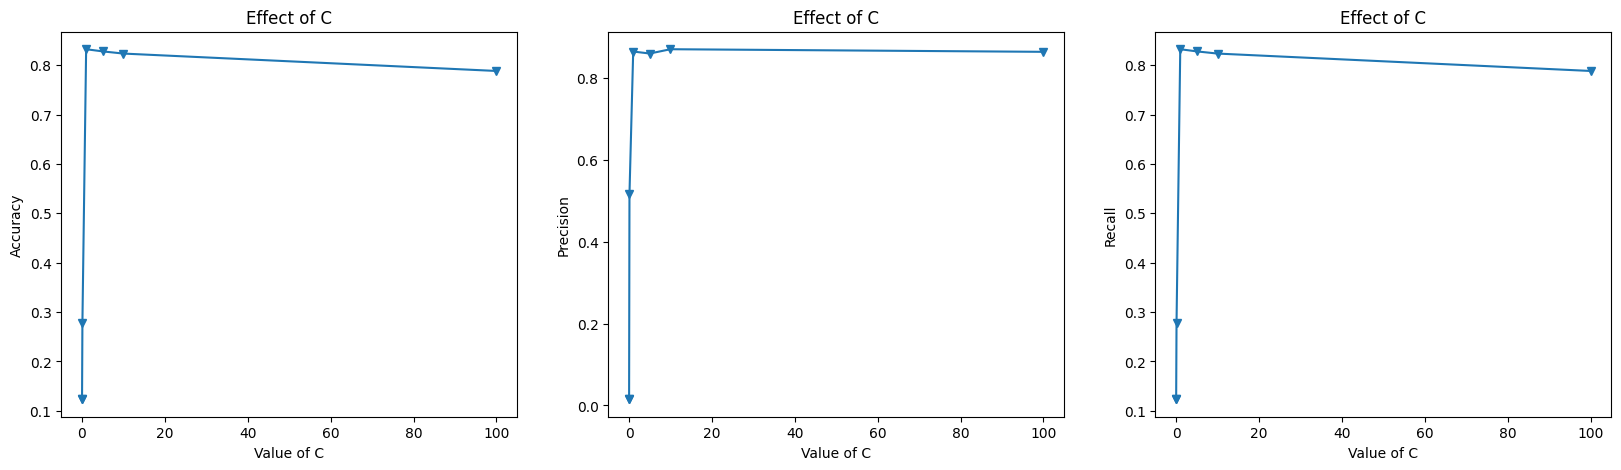

In [23]:
from sklearn.svm import SVC

list_C = [0.001, 0.01, 0.1, 1, 5.0, 10.0, 100]
models = []

for C in list_C:
    svm_classification = SVC(C = C, kernel = 'linear')
    svm_classification.fit(X_train, y_train)
    models.append(svm_classification)

acc, pre, re = [], [], []
for model in models:
    y_pred = model.predict(X_test)
    acc.append(accuracy_score(y_test, y_pred))
    pre.append(precision_score(y_test, y_pred, average = 'weighted'))
    re.append(recall_score(y_test, y_pred, average = 'weighted'))

fig, axs = plt.subplots(1, 3, figsize = (20, 5))

axs[0].plot(list_C, acc, marker = "v")
axs[0].set_xlabel("Value of C")
axs[0].set_ylabel("Accuracy")
axs[0].set_title("Effect of C")

axs[1].plot(list_C, pre, marker = "v")
axs[1].set_xlabel("Value of C")
axs[1].set_ylabel("Precision")
axs[1].set_title("Effect of C")

axs[2].plot(list_C, re, marker = "v")
axs[2].set_xlabel("Value of C")
axs[2].set_ylabel("Recall")
axs[2].set_title("Effect of C")

plt.show()

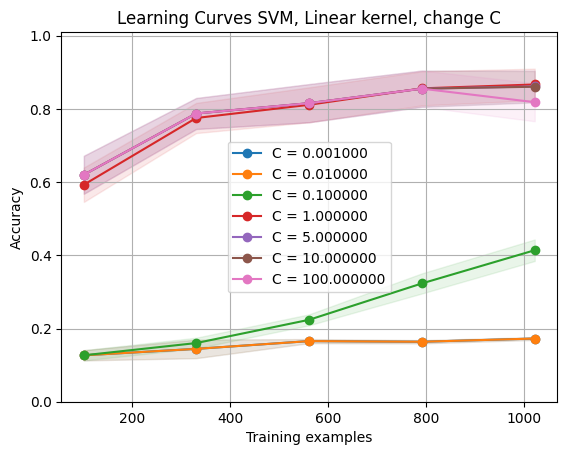

In [ ]:
# Answer

# hàm sinh id màu  
def get_cmap(n):
    return 'C' + str(n)

# Hàm thực hiện training model, crossvalidate và vẽ lên đồ thị sử dụng mat libplot 
def plot_learning_curve(estimator, title, label_curve, X, y, ylim = None, cv = None,
                        n_jobs = 1, train_sizes = np.linspace(.1, 1.0, 5), new_plot = False,
                        idx_color = 0):
    
    # Khởi tạo bức ảnh mới với thư viện plot lib 
    if new_plot:
        # plt.figure()
        plt.title(title)
        plt.xlabel("Training examples")
        plt.ylabel("Accuracy")
        plt.grid()
    
    # chú thích nếu có 
    if ylim is not None:
        plt.ylim(*ylim)
        
    # thực hiện training model, ghi nhận các giá trị trong quá trình training 
    # cv = số fold cross validate, số phần bộ dữ liệu được chia để thực hiện training testing.
    # train_sizes = mảng tỉ lệ, các tỉ lệ được hệ thống chọn làm điểm dừng để thực hiện 1 testing 
    #  train_sizes = [0.3, 0.5] => hệ thống lấy 30 % dữ liệu để train và thực hiện test, tương tự 50 % ..
    # scoring = hàm mục tiêu để đánh giá chất lượng mô hình và vẽ lên đồ thị 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="accuracy")
    
    # Lấy trung bình cộng các giá trị output của các fold 
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    
    # random 1 màu để vẽ 
    color = get_cmap(idx_color)
    
    # thực hiện vẽ các giá trị số lên đồ thị với màu vừa được random 
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha = 0.1, color = color)
    plt.plot(train_sizes, test_scores_mean, 'o-', color = color,
             label = label_curve)

    plt.legend(loc = "best")
    return plt

list_C = [0.001, 0.01, 0.1, 1, 5.0, 10.0, 100]
# model title 
title = "Learning Curves SVM, Linear kernel, change C"

# duyệt qua mảng các giá trị của tham số C 
for i, C in enumerate(list_C):
    # Với từng giá trị C nhận được, 
    # thực hiện build model và training cross-validate 
    # vẽ kết quả tìm được lên đồ thị đường. 
    text_clf = Pipeline([ 
                         ('clf', svm.SVC(kernel = 'linear', C = C)), # mô hình svm với tham số C 
                         ])
    
    plt = plot_learning_curve(text_clf, title, "C = %f" % (C),
                              data_preprocessed, data_train.target,
                              (0.0, 1.01), cv = 10, n_jobs = -1, idx_color = i, new_plot = i == 0)

# lưu hình ảnh ra file 
# plt.savefig('images/changeC.png', bbox_inches='tight')
plt.show()


2. Sử dụng GridSearchCV để tìm bộ tham số tốt nhất

In [ ]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 5.0, 10.0, 100], 
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': [0.0001, 0.001, 0.01, 0.1],}

grid_search = GridSearchCV(
    estimator = SVC(),
    param_grid = param_grid,
    cv = 10,
    scoring = 'accuracy',
    n_jobs = -1,
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

Best Parameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Best CV Accuracy: 0.8601221001221001
